## Finding out the distribution of the target

I will try to find the distribution of the target per `time_id`, meaning I fix `time_id` to be some value and see what kind of distribution it is.

In [13]:
import pandas as pd
import polars as pl
import numpy as np
from scipy.stats import norm, t, shapiro, probplot
import pylab 
import matplotlib.pyplot as plt

In [14]:
## Import the dataset here. I used the parquet file format for the data.

df = pd.read_parquet('parquet/train_low_mem.parquet')

This is the histogram. Set `k` to some value. 

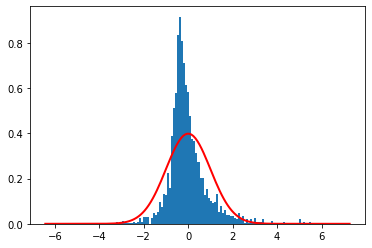

In [16]:
k = 100
data = df[df['time_id']==k]['target']
mu, std = norm.fit(data) 
#std = 0.8*std
count, bins, ignored = plt.hist((data-mu)/std, 150, density=True)
plt.plot(bins, 
         1/np.sqrt(2 * np.pi) * np.exp( - 0.5 * bins**2 ),
         linewidth=2, color='r')
plt.show()


This is the qq-plot compared with the $t$-distribution with 3 degrees of freedom. This distribution was found later using `distfit`.

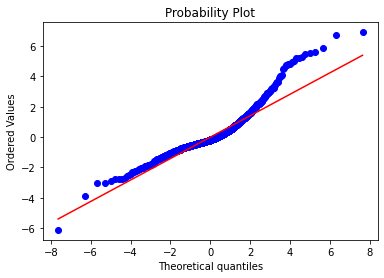

In [18]:
probplot(data, dist=t(df=5), plot=pylab)
pylab.show()

This is the qq-plot compared to the normal distribution.

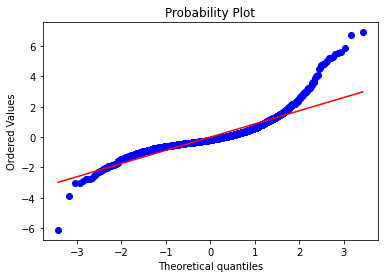

In [19]:
probplot(data, dist='norm', plot=pylab)
pylab.show()

This is where I run the [Shapiro-Wilks](https://en.wikipedia.org/wiki/Shapiro%E2%80%93Wilk_test) test.

In [9]:
shapiro(data)

ShapiroResult(statistic=0.8348259329795837, pvalue=2.0038568039844884e-43)

As we can see, the $p$-value is extremely low, so we conclude that the target is not normally distributed.

Now I'm going to run `distfit` to see what is the best fit distribution.

In [10]:
from distfit import distfit
k = 1000
data = df[df['time_id']==k]['target']
mu, std = norm.fit(data) 

dist = distfit()
data = (data-mu)/std
dist.fit_transform(data)

[distfit] >fit..
[distfit] >transform..
[distfit] >[norm      ] [0.00 sec] [RSS: 0.2510888] [loc=-0.000 scale=1.000]
[distfit] >[expon     ] [0.00 sec] [RSS: 1.6861662] [loc=-5.406 scale=5.406]
[distfit] >[pareto    ] [0.06 sec] [RSS: 1.7378979] [loc=-3378797965.319 scale=3378797959.913]
[distfit] >[dweibull  ] [0.00 sec] [RSS: 0.0324893] [loc=-0.000 scale=0.668]
[distfit] >[t         ] [0.01 sec] [RSS: 0.0205426] [loc=-0.045 scale=0.582]
[distfit] >[genextreme] [0.04 sec] [RSS: 0.3352110] [loc=-0.389 scale=1.055]
[distfit] >[gamma     ] [0.03 sec] [RSS: 0.2506541] [loc=-21.431 scale=0.047]
[distfit] >[lognorm   ] [0.07 sec] [RSS: 0.2473785] [loc=-51.347 scale=51.338]
[distfit] >[beta      ] [0.06 sec] [RSS: 0.2484331] [loc=-38.435 scale=544.012]
[distfit] >[uniform   ] [0.00 sec] [RSS: 1.4271781] [loc=-5.406 scale=9.995]
[distfit] >[loggamma  ] [0.03 sec] [RSS: 0.2625464] [loc=-208.322 scale=30.580]
[distfit] >Compute confidence interval [parametric]


{'model': {'distr': <scipy.stats._continuous_distns.t_gen at 0x127c1f8b0>,
  'stats': 'RSS',
  'params': (2.4716927219230547, -0.044733101600597, 0.5817876456046129),
  'name': 't',
  'model': <scipy.stats._distn_infrastructure.rv_frozen at 0x1772bc1c0>,
  'score': 0.02054256568408061,
  'loc': -0.044733101600597,
  'scale': 0.5817876456046129,
  'arg': (2.4716927219230547,),
  'CII_min_alpha': -1.5418440626159158,
  'CII_max_alpha': 1.4523778594147212},
 'summary':          distr     score  LLE                loc              scale  \
 0            t  0.020543  NaN          -0.044733           0.581788   
 1     dweibull  0.032489  NaN               -0.0           0.667664   
 2      lognorm  0.247378  NaN         -51.347042          51.337741   
 3         beta  0.248433  NaN         -38.434803         544.011598   
 4        gamma  0.250654  NaN         -21.430998           0.047161   
 5         norm  0.251089  NaN               -0.0                1.0   
 6     loggamma  0.262546 

In [11]:
dist.summary

,distr,score,LLE,loc,scale,arg
0,t,0.020543,NaN,-0.044733,0.581788,"(2.4716927219230547,)"
1,dweibull,0.032489,NaN,-0.0,0.667664,"(0.9592756935976424,)"
2,lognorm,0.247378,NaN,-51.347042,51.337741,"(0.019450522273949063,)"
3,beta,0.248433,NaN,-38.434803,544.011598,"(1374.08463415194, 18074.796269989325)"
4,gamma,0.250654,NaN,-21.430998,0.047161,"(454.48837987065485,)"
5,norm,0.251089,NaN,-0.0,1.0,()
6,loggamma,0.262546,NaN,-208.322468,30.580261,"(909.4751696940791,)"
7,genextreme,0.335211,NaN,-0.388671,1.054654,"(0.19522651612051128,)"
8,uniform,1.427178,NaN,-5.406175,9.99498,()
9,expon,1.686166,NaN,-5.406175,5.406175,()


[distfit] >plot summary..


(<Figure size 1080x576 with 1 Axes>,
 <AxesSubplot:title={'center':'Best fit: t'}, xlabel='Distribution name', ylabel='RSS (lower is better)'>)

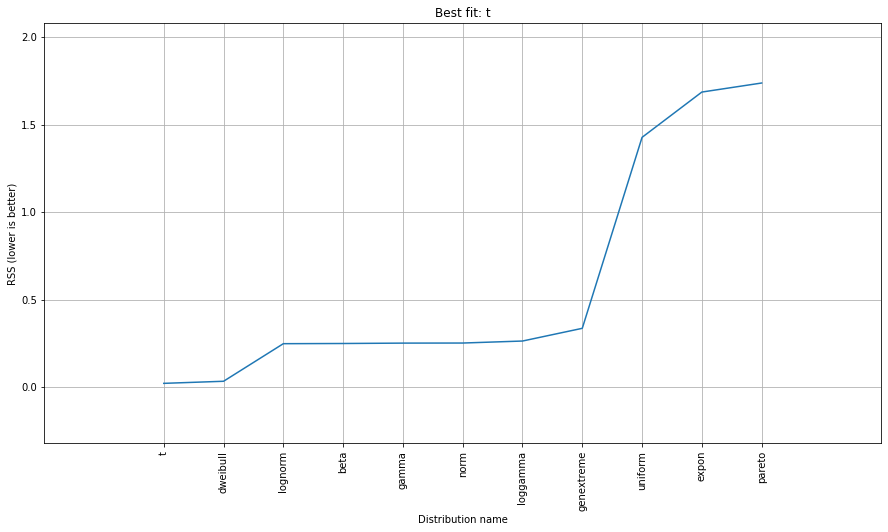

In [12]:
dist.plot_summary()

It seems that the $t$-dsitribution is the best.